In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # this increases width to full screen

In [17]:
import numpy as np # import numerical python
import scipy as sp # import scientific python
import matplotlib.pyplot as plt # import plotting functions
import seaborn as sns # import nicer plotting functions
import pandas as pd # import pandas to import data
import xarray as xr
import os # import os to make filenames etc
from copy import deepcopy # import for copying
from scipy.special import erf # need error function for distribution

import seaborn as sns
import scipy.stats as stats
import warnings

from pylab import *
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution
from scipy.optimize import least_squares
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.stats import t
from scipy.special import gamma
from pynverse import inversefunc

In [22]:
    def bhattacharyya_distance(x, distribution1, distribution2):
        """ Estimate Bhattacharyya Distance (between General Distributions)

        Args:
            distribution1: a sample distribution 1
            distribution2: a sample distribution 2

        Returns:
            Bhattacharyya distance
        """
        if len(distribution1) != len(distribution2):
            raise Exception("Distribution 1 does not equal length of Distribution 2")
        DB = np.trapz(np.sqrt(distribution1*distribution2), x=x)
        BD = -np.log(DB)
        if BD < 0:
            BD = 0
        return BD

In [107]:
# define our gaussian convolved-with-an-exp distribution
class gaussexp_dist(stats.rv_continuous):
    
    def __init__(self, tau, amps, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # init our variance
        self.sigma = sigma
        self.tau = np.nanmean(tau)
        self.amps_n = np.array(np.divide(np.array(amps), np.sum(amps))) # make normalised array of amplitudes
        self.amps_m = np.tile(self.amps_n, (1,1)) # make matrix of amps
        self.k = np.tile(np.divide(1., tau), (1, 1))  # make matrix of ks
        # init our cdf and ppf functions
        self.cdf_func, self.ppf_func = self.create_cdf_ppf()
        
    # function to return gaussian-convolved exponential pdf
    def expgauss_p(self, x):
        # expgauss pdf function
        # outputs normalised exponential convolved with gaussian 
        # ================INPUTS============= 
        # x ix data points to evaluate pdf
        # ================OUTPUT============= 
        # simulated signal
        erfterm = 1. + erf(np.divide(np.subtract(x, np.multiply(self.k.T, np.square(self.sigma))), np.sqrt(2)*self.sigma)) # create the error function term
        gaussterm = np.exp(np.divide(np.multiply(np.square(self.k.T), np.square(self.sigma)), 2.)) # create the gaussian term
        return np.nansum(np.multiply(np.divide(np.multiply(self.k, self.amps_m), 2.).T, np.multiply(np.multiply(np.exp(np.multiply(-self.k.T, x)), gaussterm), erfterm)), axis=0) # create the convolution
    
    # function to return gaussian-convolved exponential cdf       
    def expgausscdf(self, x):
        # expgauss cdf function
        # outputs normalised exponential convolved with gaussian 
        # ================INPUTS============= 
        # x ix data points to evaluate pdf
        # ================OUTPUT============= 
        # simulated signal
        term0 = np.exp((np.square(self.k.T)*np.square(self.sigma))/2 - self.k.T*x)
        term1 = (0.5)*np.exp((np.square(self.k.T)*np.square(self.sigma))/2 + self.k.T*(x - self.k.T*(np.square(self.sigma))))*erf(np.divide(x, np.sqrt(2)*self.sigma))
        term2 = (0.5)*erf(np.divide(x - self.k.T*np.square(self.sigma), np.sqrt(2)*self.sigma))
        cdf = self.amps_m.T*(0.5 + (term0*(term1 - term2 - 0.5)))
        return np.squeeze(np.nansum(cdf, axis=0))
    
    def linlogscale(self, linstart, linend, logend, nlinpoints):
        M = int(np.multiply(nlinpoints, np.add(1., np.log10(logend))))
        linpoints = np.linspace(linstart, linend, nlinpoints)
        logpoints = np.logspace(np.log10(linend + np.diff(linpoints)[-1]), np.log10(logend), M)
        return np.hstack([linpoints, logpoints])
    
    # function to
    def create_cdf_ppf(self):
        # define domain as -20 sigma to +20 tau
        xs = self.linlogscale(-20*self.sigma, 10*self.sigma, 20*self.tau, 500001)
        # cumsum to form cdf
        my_cdf = self.expgausscdf(xs)
        # create cdf and ppf
        func_cdf = lambda x: self.expgausscdf(x)
        func_ppf = interp1d(my_cdf, xs, fill_value='extrapolate')
        return func_cdf, func_ppf
        
    # pdf function for exp gauss
    def _pdf(self, x):
        return self.expgauss_p(x)
    
    # cdf function
    def _cdf(self, x):
        return self.cdf_func(x)
    
    # inverse cdf function
    def _ppf(self, x):
        return self.ppf_func(x)

In [108]:
10000001/2

5000000.5

In [109]:
def linlogscale(linstart, linend, logend, nlinpoints):
    M = int(np.multiply(nlinpoints, np.add(1., np.log10(logend))))
    linpoints = np.linspace(linstart, linend, nlinpoints)
    logpoints = np.logspace(np.log10(linend + np.diff(linpoints)[-1]), np.log10(logend), M)
    return np.hstack([linpoints, logpoints])

In [110]:
tau = 5
amps = 1
sigma = 0.1
mydist = gaussexp_dist(tau, amps, sigma)

124 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [108]:
    def expgauss(x, tau, sigma, mu, amps):
        # expgauss function
        # outputs normalised sum-of-exponentials convolved with gaussians 
        # ================INPUTS============= 
        # x ix data points to evaluate pdf
        # tau is array of lifetimes (one gives mono-exponential, etc.)
        # sigma is sigma of gaussian to convolve with exponential
        # mu is centre of gaussian
        # amps is amplitudes of taus
        # ================OUTPUT============= 
        # simulated signal
        amps_n = np.array(np.divide(np.array(amps), np.sum(amps))) # make normalised array of amplitudes
        ampsm = np.tile(amps_n, (1,1)) # make matrix of amps
        ksm = np.tile(np.divide(1., tau), (1, 1))  # make matrix of ks
        erfterm = 1. + erf(np.divide(np.subtract(x, np.multiply(ksm.T, np.square(sigma))), np.sqrt(2)*sigma)) # create the error function term
        gaussterm = np.exp(np.divide(np.multiply(np.square(ksm.T), np.square(sigma)), 2.)) # create the gaussian term
        return np.nansum(np.multiply(np.divide(np.multiply(ksm, ampsm), 2.).T, np.multiply(np.multiply(np.exp(np.multiply(-ksm.T, x)), gaussterm), erfterm)), axis=0) # create the convolution


In [ ]:
def TCSPCsimulator(tau, nphotons, sbr, t):
    # TCSPCsimulator function
    # outputs TCSPC-type data of nphotons binned as would be in TCSPC technique
    # ================INPUTS============= 
    # tau is lifetime
    # nphotons is how many photons in total to simulate
    # sbr is signal-to-background ratio (0 gives no background photons)
    # t is bins in time
    # ================OUTPUT============= 
    # histogram
    if sbr == 0:
        nsignal = int(nphotons)
        nbackground = int(0)
    else:
        nbackground = int(nphotons/sbr) # get number of background photons
        nsignal = int(nphotons - nbackground) # get number of signal photons
    background, bins = np.histogram(np.random.rand(nbackground)*np.max(t), bins=t) # get background
    signal, bins = np.histogram(np.random.exponential(tau, size=nsignal), bins=t) # get signal
    if np.sum(signal) < nsignal:
        while np.sum(signal) < nsignal:
            defecit = nsignal - np.sum(signal)
            signal2, bins = np.histogram(np.random.exponential(tau, size=defecit), bins=t) # get more signal
            signal = signal + signal2
    overall = signal + background
    return overall

In [111]:
def expgauss(x, tau, sigma):
    # expgauss function
    # outputs normalised sum-of-exponentials convolved with gaussians 
    # ================INPUTS============= 
    # x ix data points to evaluate pdf
    # tau is one lifetime
    # sigma is sigma of gaussian to convolve with exponential
    # ================OUTPUT============= 
    # simulated signal
    ksm = np.tile(np.divide(1., tau), (1, 1))  # make matrix of ks
    erfterm = 1. + erf(np.divide(np.subtract(x, np.multiply(ksm.T, np.square(sigma))), np.sqrt(2)*sigma))
    gaussterm = np.exp(np.divide(np.multiply(np.square(ksm.T), np.square(sigma)), 2.))
    return np.nansum(np.multiply(np.divide(np.multiply(1., ksm), 2.).T, np.multiply(np.multiply(np.exp(np.multiply(-ksm.T, x)), gaussterm), erfterm)), axis=0)

$\exp((k^2 σ^2)/2 - k x) (1/2 \exp((k^2 σ^2)/2 + k (x - k(σ^2))) \mathrm{erf}((k σ^2 - k(σ^2) + x)/(\sqrt{2} σ)) - 1/2 \mathrm{erf}((x - k(σ^2))/(\sqrt{2} σ)) - 1/2)$ + constant

by induction constant is 0.5

In [112]:
def TCSPCsimulator_IRF(tau, sigma, nphotons, sbr, t):
    # TCSPCsimulator function
    # outputs TCSPC-type data of nphotons binned as would be in TCSPC technique
    # ================INPUTS============= 
    # tau is lifetime
    # sigma is width
    # nphotons is how many photons in total to simulate
    # sbr is signal-to-background ratio (0 gives no background photons)
    # t is bins in time
    # ================OUTPUT============= 
    # histogram
    if sbr == 0:
        nsignal = int(nphotons)
        nbackground = int(0)
    else:
        nbackground = int(nphotons/sbr) # get number of background photons
        nsignal = int(nphotons - nbackground) # get number of signal photons
    my_dist = gaussexp_dist(tau, 1., sigma)    
    background, bins = np.histogram(np.random.uniform(np.min(t), np.max(t), nbackground), bins=t) # get background
    signal, bins = np.histogram(my_dist.rvs(size=nsignal), bins=t) # get signal
    if np.sum(signal) < nsignal:
        while np.sum(signal) < nsignal:
            defecit = nsignal - np.sum(signal)
            signal2, bins = np.histogram(my_dist.rvs(size=defecit), bins=t) # get more signal
            signal = signal + signal2
    overall = signal + background
    return overall

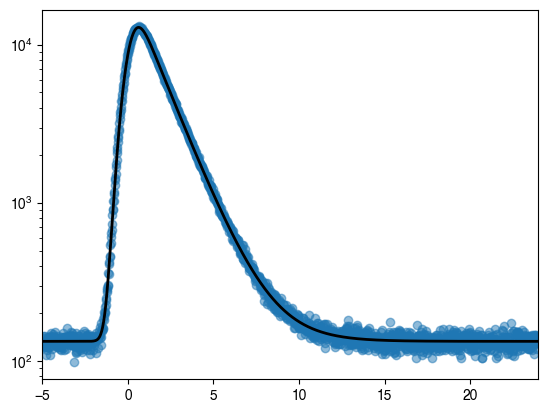

In [114]:
nphotons = 2000000
tau = 1.6
sigma = 0.5
t_bins = np.linspace(-sigma*10, tau*15, int((tau*15)/0.016)+2);
t = np.linspace(-sigma*10, tau*15, int((tau*15)/0.016)+1);
sbr = 10
test = TCSPCsimulator_IRF(tau, sigma, nphotons, sbr, t_bins)
plt.scatter(t, test, alpha=0.5)
b = 1./sbr
a = 1 - b
# a is exp, b is background
fit = a*expgauss(t, tau, sigma) + b/(np.max(t) - np.min(t))
fit = fit/np.sum(fit)
fit = nphotons*fit
plt.plot(t, fit, lw=2, color='k')
plt.yscale('log')
plt.xlim([-sigma*10, np.max(t)])
plt.show(block=False)